# 設備資訊

In [1]:
print('==============   GPU 資訊   ==============')
!/opt/bin/nvidia-smi

print('==============   CPU 資訊   ==============')
!cat /proc/cpuinfo | grep model\ name 

==============   GPU 資訊   ==============
Wed Mar 22 04:53:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                               

# 訓練 LSTM 模型

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, CSVLogger

## 載入資料

In [3]:
data = pd.read_csv('data.csv')

## 分割特徵和標籤

In [4]:
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

## 將標籤轉換為 one-hot 編碼

In [5]:
y = np.eye(2)[y]

## 將數據集分割為訓練集和測試集

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 模型參數

In [7]:
hidden_units = 512
output_units = 2
learning_rate = 0.001
batch_size = 1280
epochs = 500

checkpoint_file = 'model_weights.h5'
logger_file = 'training_log.csv'

## 創建 LSTM 模型

In [8]:
model = Sequential()
model.add(LSTM(units=512, input_shape=(X_train.shape[1], 1), activation='tanh'))
model.add(Dense(units=2, activation='softmax'))

## 設置優化器、損失函數和指標

In [9]:
optimizer = Adam(learning_rate=learning_rate)
loss = categorical_crossentropy
metrics = ['accuracy']

checkpoint_callback = ModelCheckpoint(checkpoint_file, monitor='val_loss', save_best_only=True)
logger_callback = CSVLogger(logger_file)

## 編譯模型

In [10]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## 模型結構

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 512)               1052672   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 1,053,698
Trainable params: 1,053,698
Non-trainable params: 0
_________________________________________________________________


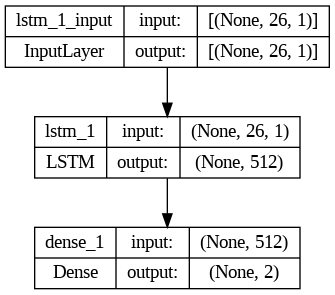

In [11]:
model.summary()

plot_model(model, show_shapes=True, to_file='model.png')

## 訓練模型

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[checkpoint_callback, logger_callback])

Epoch 1/500
100/100 [==============================] - 3s 14ms/step - loss: 0.4694 - accuracy: 0.8105 - val_loss: 0.4582 - val_accuracy: 0.8154
Epoch 2/500
100/100 [==============================] - 1s 9ms/step - loss: 0.4415 - accuracy: 0.8185 - val_loss: 0.4258 - val_accuracy: 0.8271
Epoch 3/500
100/100 [==============================] - 1s 9ms/step - loss: 0.3917 - accuracy: 0.8355 - val_loss: 0.3586 - val_accuracy: 0.8508
Epoch 4/500
100/100 [==============================] - 1s 9ms/step - loss: 0.3253 - accuracy: 0.8650 - val_loss: 0.3086 - val_accuracy: 0.8713
Epoch 5/500
100/100 [==============================] - 1s 9ms/step - loss: 0.2886 - accuracy: 0.8849 - val_loss: 0.2736 - val_accuracy: 0.8919
Epoch 6/500
100/100 [==============================] - 1s 9ms/step - loss: 0.2616 - accuracy: 0.8973 - val_loss: 0.2638 - val_accuracy: 0.8960
Epoch 7/500
100/100 [==============================] - 1s 9ms/step - loss: 0.2451 - accuracy: 0.9044 - val_loss: 0.2430 - val_accuracy: 0.906

## 評估模型

In [13]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
loss, accuracy = model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

1000/1000 [==============================] - 3s 3ms/step - loss: 0.1022 - accuracy: 0.9781
Test loss: 0.10224159806966782
Test accuracy: 0.9780625104904175


## 輸出訓練結果

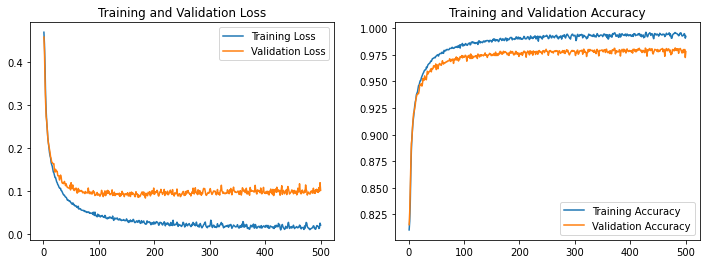

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
from keras.utils import plot_model

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()
plt.savefig('accuracy.png')

## 預測結果

In [15]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

correct = np.nonzero(y_pred_labels == y_test_labels)[0]
incorrect = np.nonzero(y_pred_labels != y_test_labels)[0]

print(f'Correct predictions: {len(correct)}, Incorrect predictions: {len(incorrect)}')

1000/1000 [==============================] - 2s 2ms/step
Correct predictions: 31298, Incorrect predictions: 702


## 混淆矩陣

1000/1000 [==============================] - 2s 2ms/step


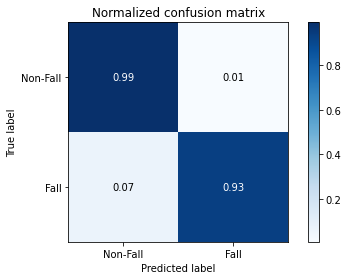

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


# 讀取測試集資料
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 進行預測
y_pred = model.predict(X_test)

# 將預測結果轉換為類別
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 計算混淆矩陣
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# 定義函數繪製混淆矩陣圖
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
  if not title:
    if normalize:
      title = 'Normalized confusion matrix'
    else:
      title = 'Confusion matrix, without normalization'

  # 計算混淆矩陣
  cm = confusion_matrix(y_true, y_pred)

  # 將類別名稱儲存在陣列中
  classes = classes[unique_labels(y_true, y_pred)]

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  # 繪製圖形
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=classes,
    yticklabels=classes,
    title=title,
    ylabel='True label',
    xlabel='Predicted label')

  # 設置文字標籤
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt),
        ha='center', va='center',
        color='white' if cm[i, j] > thresh else 'black')

  fig.tight_layout()
  return ax

# 繪製混淆矩陣圖
plot_confusion_matrix(y_true_classes, y_pred_classes, classes=np.array(['Non-Fall', 'Fall']), normalize=True, title='Normalized confusion matrix')
plt.show()